In [1]:
import pandas as pd
#from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("train.csv")
data.info()

Data Notes:
You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

Data range: Jan 1, 2011 to Dec 12, 2012

datetime - hourly date + timestamp <br>
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter <br>
holiday - whether the day is considered a holiday<br>
workingday - whether the day is neither a weekend nor holiday<br>
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy <br>
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist <br>
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds <br>
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog <br>
temp - temperature in Celsius<br>
atemp - "feels like" temperature in Celsius<br>
humidity - relative humidity<br>
windspeed - wind speed<br>
casual - number of non-registered user rentals initiated<br>
registered - number of registered user rentals initiated<br>
count - number of total rentals<br>

Notation notes: think of variable 'data' as the raw data table

# Data Preparation

Cleaning up the date format:
- convert to datetime
- change index
- add date col
- add y,m,d,hr cols
- drop datetime col

In [43]:
data['datetime'] = pd.to_datetime(data.datetime)
data.index = data.datetime
data['date'] = data['datetime'].dt.date

data['year'] = data['datetime'].dt.year
data['month'] = data['datetime'].dt.month
data['day'] = data['datetime'].dt.day
data['hour'] = data['datetime'].dt.hour
data = data.drop(["datetime"], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10887 entries, 2011-01-01 00:00:00 to NaT
Data columns (total 16 columns):
season        10886 non-null float64
holiday       10886 non-null float64
workingday    10886 non-null float64
weather       10886 non-null float64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null float64
windspeed     10886 non-null float64
casual        10886 non-null float64
registered    10886 non-null float64
count         10886 non-null float64
date          10886 non-null object
hour          10886 non-null float64
year          10886 non-null float64
month         10886 non-null float64
day           10886 non-null float64
dtypes: float64(15), object(1)
memory usage: 1.4+ MB


### Change to categorical variables

In [45]:
cat_vars = ["season","holiday","workingday","weather","hour","year","month","day"]
for var in cat_vars:
    data[var] = data[var].astype("category")

# Visualizing Data

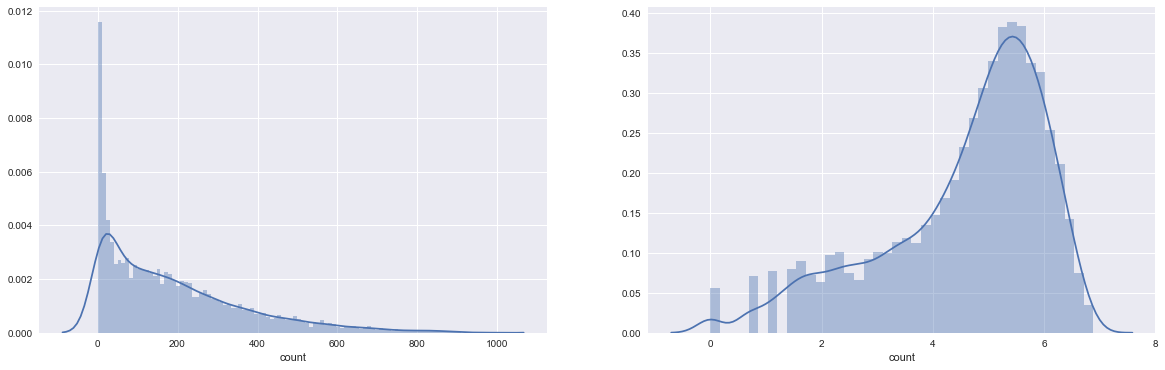

In [29]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(20, 6)
sns.distplot(data['count'], bins=100, ax=axes[0])
sns.distplot(np.log(data['count']),ax=axes[1])
plt.show()  

### Visualizing the weather category

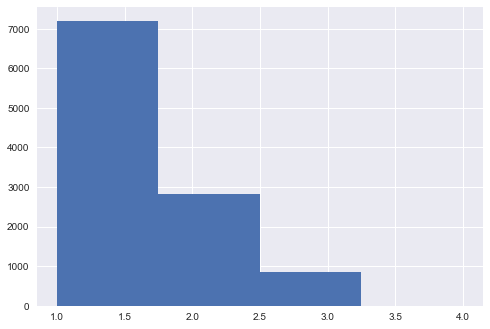

In [6]:
plt.hist(data['weather'], bins = 4)
plt.show()

In [7]:
data.groupby('weather').count() #interesting... only one hour from all the data is classified as 4 for the weather

,datetime,season,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,date
weather,,,,,,,,,,,,
1,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192,7192
2,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834,2834
3,859,859,859,859,859,859,859,859,859,859,859,859
4,1,1,1,1,1,1,1,1,1,1,1,1


Lets drop the weather category 4 entry


In [55]:
data = data[data.weather != 4]

### Workday vs Holiday vs Weekend Count Means

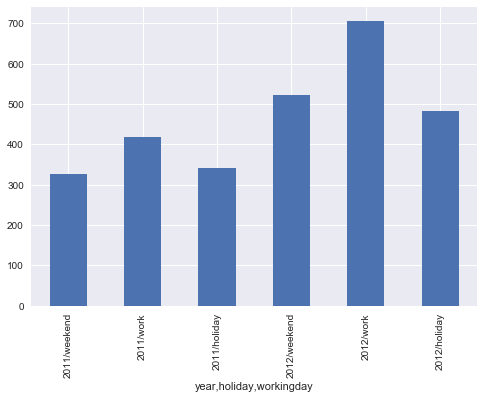

In [118]:
whw = data.groupby(['date', 
                    'holiday', 
                    'workingday', 
                    'year'])['count'].max().groupby(['year','holiday', 'workingday']).mean()
                                                                    
ax = whw.plot(kind = 'bar')
ax.set_xticklabels(['2011/weekend', '2011/work', '2011/holiday', '2012/weekend', '2012/work', '2012/holiday'])
plt.show()

#unneccessary code:
#whw = pd.DataFrame(whw)
#whw.loc[:, 'weekend'] =  np.logical_not(np.logical_or(np.array(whw.index.get_level_values(1)), 
#                                                      np.array(whw.index.get_level_values(2)))).astype(int)
#whw.loc[:, 'hldy'] = np.array(whw.index.get_level_values(1))
#whw.loc[:, 'wrkday'] = np.array(whw.index.get_level_values(2))
#whw.groupby(['hldy', 'wrkday']).mean().plot(kind = 'bar')


### Year and Season vs Mean Daily Maximum Count

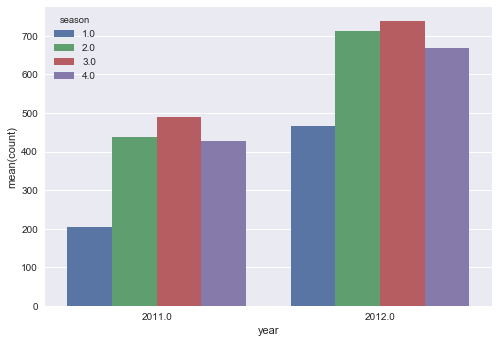

In [115]:
seasonal_avgs = data.groupby([data.date, 
                              data.season, data.year])['count'].max().groupby(['year', 'season']).mean()
seasonal_avgs = pd.DataFrame(seasonal_avgs).reset_index()

#seasonal_avgs.plot(kind = 'bar')
sns.barplot(data = seasonal_avgs, x = 'year', y ='count', hue = 'season')
#ew_labels = ['Spring', 'Summer', 'Fall', 'Winter']
#for t, l in zip(p._legend.texts, new_labels): t.set_text(l)
sns.plt.show()

### Mean Count over the period of a Day:

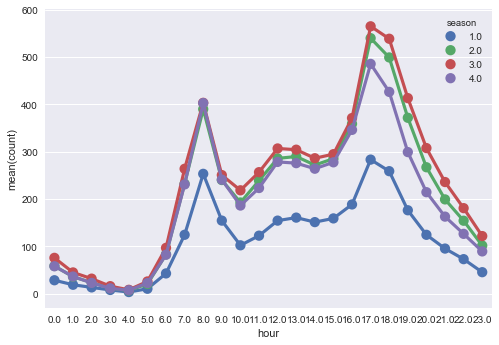

In [92]:
by_hour = data.groupby(['hour', 'season'])['count'].mean()
by_hour = pd.DataFrame(by_hour).reset_index()
sns.pointplot(data=by_hour, x='hour',y='count',hue='season')
plt.show()

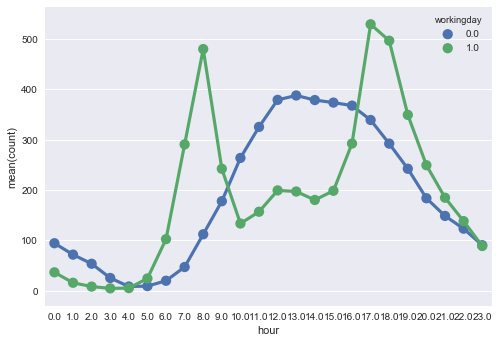

In [109]:
by_day = data.groupby(['hour', 'workingday'])['count'].mean()
by_day = pd.DataFrame(by_day).reset_index()
sns.pointplot(data=by_day, x='hour',y='count', hue='workingday')
plt.show()

### Examining the effect of windspeed

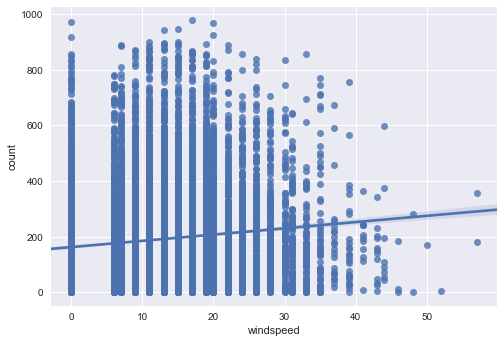

In [13]:
sns.regplot(x="windspeed", y="count", data=data)
plt.show()

### General Correlation Coefficient analysis
Given so many datapoints (~10^4), p-values for pearson correlation coeff are going to be <<<0.05


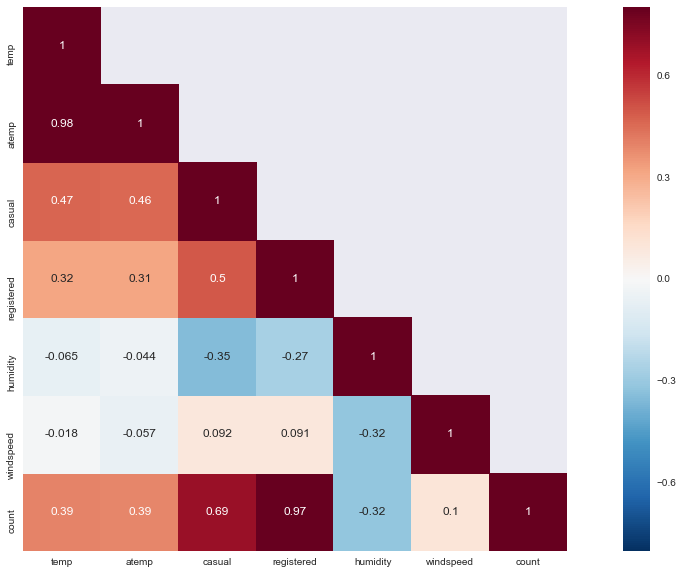

In [14]:
corMatt = data[["temp","atemp","casual","registered","humidity","windspeed","count"]].corr()
mask = np.array(corMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corMatt, mask=mask,vmax=.8, square=True,annot=True)
plt.show()

In [15]:
#check a few p-values to be sure
out = []
out.append(sp.stats.pearsonr(data['temp'], data.atemp))
out.append(sp.stats.pearsonr(data['windspeed'], data['count']))
out.append(sp.stats.pearsonr(data['humidity'], data['count']))
out

[(0.98494811048170727, 0.0),
 (0.10136947021033278, 2.8984072031669372e-26),
 (-0.31737147887659456, 2.9215416637500742e-253)]

#### Analysis:
'atemp' and temp are highly correlated (0.98) hence we will drop atemp from the MLR model
Additionally there are many 0 values for windspeed and this predictor has a low correlation coefficient.

We will drop atemp and windspeed from the MLR model

### Pair plot to confirm coeff analysis and catch any other irregularities

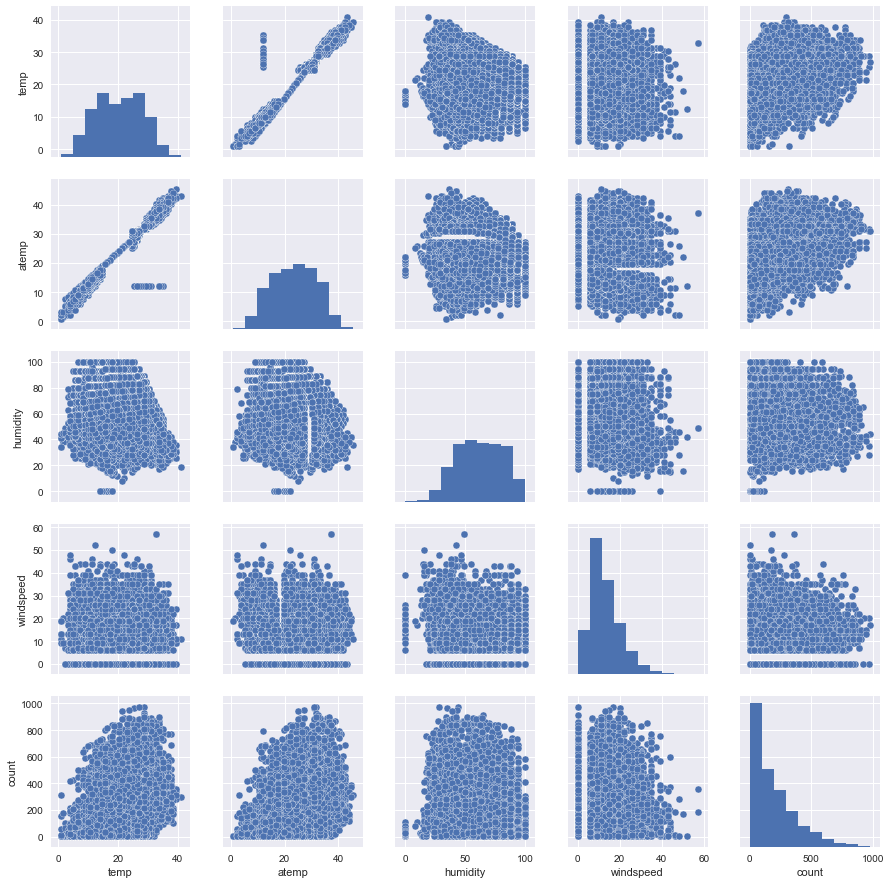

In [38]:
num_vars = ['temp', 'atemp', 'humidity','windspeed', 'count']
sns.pairplot(data, vars = num_vars)
plt.show()

### Analysis:

region of discontinuity between 0 and above for windspeed plots. -> drop windspeed <br>
atemp and temp highly correlated -> drop <br>
weird data with atemp ~ 11C and temp \in [25,35] C... <br>
other data look like unorganized blobs -> not/weakly correlated <br>

# Multiple Linear Regreesion Model
## Dropping variables

In [60]:
drop_vars = ['windspeed', 'atemp', 'date']
dataDropped = data.drop(drop_vars, axis = 1)
dataDropped.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to NaT
Data columns (total 13 columns):
season        10885 non-null category
holiday       10885 non-null category
workingday    10885 non-null category
weather       10885 non-null category
temp          10885 non-null float64
humidity      10885 non-null float64
casual        10885 non-null float64
registered    10885 non-null float64
count         10885 non-null float64
hour          10885 non-null category
year          10885 non-null category
month         10885 non-null category
day           10885 non-null category
dtypes: category(8), float64(5)
memory usage: 598.0 KB


In [176]:
reg_cat_vars = ['season','weather','hour','year','month']
cat_dummies = pd.get_dummies(data[reg_cat_vars])
dataReg = pd.concat([dataDropped[['temp','humidity','holiday','workingday']], cat_dummies], axis=1)
dataReg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to NaT
Data columns (total 50 columns):
temp           10885 non-null float64
humidity       10885 non-null float64
holiday        10885 non-null category
workingday     10885 non-null category
season_1.0     10886 non-null uint8
season_2.0     10886 non-null uint8
season_3.0     10886 non-null uint8
season_4.0     10886 non-null uint8
weather_1.0    10886 non-null uint8
weather_2.0    10886 non-null uint8
weather_3.0    10886 non-null uint8
weather_4.0    10886 non-null uint8
hour_0.0       10886 non-null uint8
hour_1.0       10886 non-null uint8
hour_2.0       10886 non-null uint8
hour_3.0       10886 non-null uint8
hour_4.0       10886 non-null uint8
hour_5.0       10886 non-null uint8
hour_6.0       10886 non-null uint8
hour_7.0       10886 non-null uint8
hour_8.0       10886 non-null uint8
hour_9.0       10886 non-null uint8
hour_10.0      10886 non-null uint8
hour_11.0      10886 non-null uint

In [181]:
train = dataReg[:-1]
yCount = dataDropped['count'][:-1]
train = train.drop('weather_4.0',axis = 1)

In [182]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [186]:
from sklearn.linear_model import LinearRegression
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)

linModel = LinearRegression()

linModel.fit(X = train, y = yCount)

# Make predictions
preds = linModel.predict(X= train)
print ("RMSLE Value For Linear Regression: ",rmsle(np.exp(yCount),np.exp(preds),False))

('RMSLE Value For Linear Regression: ', inf)


C:\Users\dhamm\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':
C:\Users\dhamm\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in square
  import sys


In [183]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10885 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 49 columns):
temp           10885 non-null float64
humidity       10885 non-null float64
holiday        10885 non-null category
workingday     10885 non-null category
season_1.0     10885 non-null uint8
season_2.0     10885 non-null uint8
season_3.0     10885 non-null uint8
season_4.0     10885 non-null uint8
weather_1.0    10885 non-null uint8
weather_2.0    10885 non-null uint8
weather_3.0    10885 non-null uint8
hour_0.0       10885 non-null uint8
hour_1.0       10885 non-null uint8
hour_2.0       10885 non-null uint8
hour_3.0       10885 non-null uint8
hour_4.0       10885 non-null uint8
hour_5.0       10885 non-null uint8
hour_6.0       10885 non-null uint8
hour_7.0       10885 non-null uint8
hour_8.0       10885 non-null uint8
hour_9.0       10885 non-null uint8
hour_10.0      10885 non-null uint8
hour_11.0      10885 non-null uint8
hour_12.0      108